This function shows how to use TensorFlow to create a soft margin SVM
We will use the iris data, specifically: x1 = Sepal Length x2 = Petal Width
Class 1 : I. setosa Class -1: not I. setosa
We know here that x and y are linearly seperable for I. setosa classification.
Note that we implement the soft margin with an allowable margin of error for points. The margin of error term is given by 'alpha' below. To behave like a hard margin SVM, set alpha = 0. (in notebook code block #7)

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [58]:
# Loading the dataset

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()

x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y == 0 else -1 for y in iris.target])
# print('x_vals : \n', x_vals.shape)
# x_vals : 
#  (150, 2)

# 80% for training
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * .8), replace=False)

# 20% for testing
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]

y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

batch_size = 100

# placeholders
x_data = tf.placeholder(tf.float32, shape=[None, 2])
y_data = tf.placeholder(tf.float32, shape=[None, 1])

# variables
A = tf.Variable(tf.random_normal(shape=[2, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))


Declare our model and L2 Norm
SVM linear model is given by the equation:
$$\left[ \frac{1}{n} \sum_{i=1}^{n} \max(0, 1 - A \cdot x - b) \right] + \alpha \cdot ||A||^{2}$$
Our loss function will be the above quantity and we will tell TensorFlow to minimize it. Note that $n$ is the number of points (in a batch),  $A$ is the hyperplane-normal vector (to solve for), $b$ is the hyperplane-offset (to solve for), and $\alpha$ is the soft-margin parameter.

Step #100 A = [[ 0.17492324]
 [-0.93209648]], b = [[ 0.72116303]]
Loss = [ 0.39254326]
Step #200 A = [[ 0.21329077]
 [-1.16210675]], b = [[ 0.659163]]
Loss = [ 0.3879796]


Step #300 A = [[ 0.26440307]
 [-1.37861848]], b = [[ 0.59636331]]
Loss = [ 0.31156102]
Step #400 A = [[ 0.29962572]
 [-1.60101068]], b = [[ 0.53446352]]
Loss = [ 0.2419337]


Step #500 A = [[ 0.31896502]
 [-1.81556928]], b = [[ 0.47666365]]
Loss = [ 0.18230301]


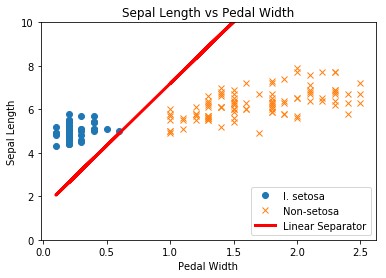

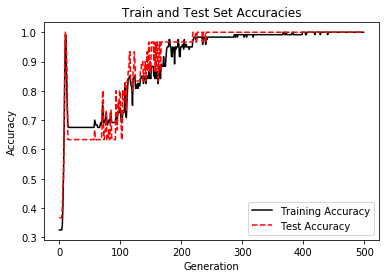

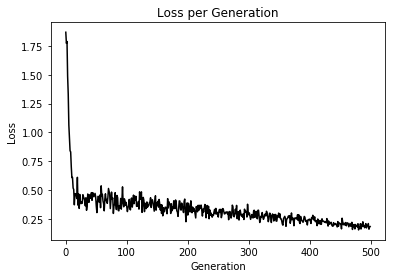

In [59]:
# Declare model operations
model_output = tf.subtract(tf.matmul(x_data, A), b)

# Declare vector L2 'norm' function squared
l2_norm = tf.reduce_sum(tf.square(A))

# Declare loss function
# Loss = max(0, 1-pred*actual) + alpha * L2_norm(A)^2
# L2 regularization parameter, alpha

alpha = tf.constant([.01])

# Margin term in loss
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(model_output, y_data))))

# Put terms together
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

# Declare prediction function
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_data), tf.float32))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
var_init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(var_init)
    # Training loop
    loss_vec = []
    train_accuracy = []
    test_accuracy = []
    for i in range(500):
        rand_index = np.random.choice(len(x_vals_train), size=batch_size)
        rand_x = x_vals_train[rand_index]
        rand_y = np.transpose([y_vals_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_data: rand_y})
        loss_vec.append(temp_loss)

        train_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_vals_train,
            y_data: np.transpose([y_vals_train])})
        train_accuracy.append(train_acc_temp)

        test_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_vals_test,
            y_data: np.transpose([y_vals_test])})
        test_accuracy.append(test_acc_temp)

        if (i + 1) % 100 == 0:
            print('Step #{} A = {}, b = {}'.format(
                str(i + 1),
                str(sess.run(A)),
                str(sess.run(b))
            ))
            print('Loss = ' + str(temp_loss))

    # Extract coefficients
    [[a1], [a2]] = sess.run(A)
    [[b]] = sess.run(b)
    slope = -a2 / a1
    y_intercept = b / a1

    # Extract x1 and x2 vals
    x1_vals = [d[1] for d in x_vals]

    # Get best fit line
    best_fit = []
    for i in x1_vals:
        best_fit.append(slope * i + y_intercept)

    # Separate I. setosa
    setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == 1]
    setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == 1]
    not_setosa_x = [d[1] for i, d in enumerate(x_vals) if y_vals[i] == -1]
    not_setosa_y = [d[0] for i, d in enumerate(x_vals) if y_vals[i] == -1]



    % matplotlib inline
    # Plot data and line
    plt.plot(setosa_x, setosa_y, 'o', label='I. setosa')
    plt.plot(not_setosa_x, not_setosa_y, 'x', label='Non-setosa')
    plt.plot(x1_vals, best_fit, 'r-', label='Linear Separator', linewidth=3)
    plt.ylim([0, 10])
    plt.legend(loc='lower right')
    plt.title('Sepal Length vs Pedal Width')
    plt.xlabel('Pedal Width')
    plt.ylabel('Sepal Length')
    plt.show()

    # Plot train/test accuracies
    plt.plot(train_accuracy, 'k-', label='Training Accuracy')
    plt.plot(test_accuracy, 'r--', label='Test Accuracy')
    plt.title('Train and Test Set Accuracies')
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Plot loss over time
    plt.plot(loss_vec, 'k-')
    plt.title('Loss per Generation')
    plt.xlabel('Generation')
    plt.ylabel('Loss')
    plt.show()
